In [4]:
import pandas as pd
# from distutils.msvccompiler import hkey_mod
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

In [1]:

from pathlib import Path

PROJECT_ROOT = Path("/Users/drorjac/PycharmProjects/OpenMesh/")
nc_file = PROJECT_ROOT / "dataset" / "sample_OpenMesh.nc"
pws_file = PROJECT_ROOT / "dataset" / "precip_wu.csv"


In [5]:
ds = xr.open_dataset(nc_file)       # xarray accepts Path objects
print("Loaded dataset:", nc_file)



Loaded dataset: /Users/drorjac/PycharmProjects/OpenMesh/dataset/sample_OpenMesh.nc


In [25]:
# -----------------------------------------------------------------------------
# 2) Examine global attributes
# -----------------------------------------------------------------------------
print("\nGlobal attributes:")
for k, v in ds.attrs.items():
    print(f"  {k}: {v}")



Global attributes:
  title: OpenMesh
  file_author_s: Dror Jacoby
  institution: WiMNet Lab, Columbia University; CellEnMon Lab, Tel-Aviv University
  date: 2025-04-23
  source: NYC Community Mesh Network: https://www.nycmesh.net/
  history: 2025-04-23: cleaned CSV → OpenSense-1.1 NetCDF FORMATS
  naming_convention: OpenSense-1.1
  license_restrictions: CC BY 4.0 – https://creativecommons.org/licenses/by/4.0/
  reference: https://github.com/drorjac/OpenMesh
  comment: Prepared for paper ‘OpenMesh: Wireless Signal Dataset for Opportunistic Urban Weather Sensing in New York City’. Conversion follows OpenSense CML spec v1.1.


In [27]:

# -----------------------------------------------------------------------------
# 3) Inspect dataset structure
# -----------------------------------------------------------------------------
print("\nDimensions:", ds.dims)
print("Coordinates:", list(ds.coords))
print("Data variables:", list(ds.data_vars))

# -----------------------------------------------------------------------------
# 4) Variable metadata
# -----------------------------------------------------------------------------
print("\nRSL attributes:", ds["rsl"].attrs)




Dimensions: FrozenMappingWarningOnValuesAccess({'time': 354241, 'sublink_id': 103})
Coordinates: ['sublink_id', 'site_0_lat', 'site_0_lon', 'site_1_lat', 'site_1_lon', 'length', 'frequency', 'polarization', 'time']
Data variables: ['rsl', 'tsl']

RSL attributes: {'units': 'dBm', 'long_name': 'received_signal_level'}


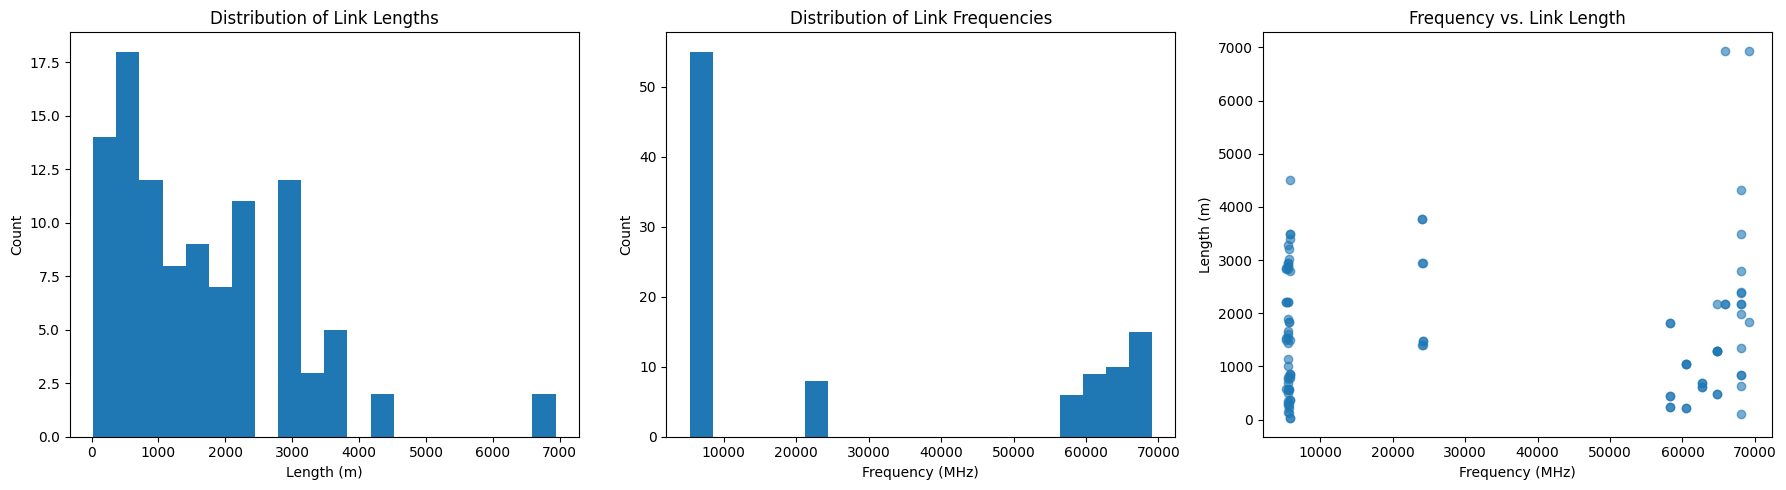

In [31]:
import matplotlib.pyplot as plt

# assume lengths and freqs are already defined:
# lengths = ds.length.values
# freqs   = ds.frequency.values

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Panel 1: Length histogram
axes[0].hist(lengths, bins=20)
axes[0].set_title("Distribution of Link Lengths")
axes[0].set_xlabel("Length (m)")
axes[0].set_ylabel("Count")

# Panel 2: Frequency histogram
axes[1].hist(freqs, bins=20)
axes[1].set_title("Distribution of Link Frequencies")
axes[1].set_xlabel("Frequency (MHz)")
axes[1].set_ylabel("Count")

# Panel 3: Scatter of Frequency vs. Length
axes[2].scatter(freqs, lengths, alpha=0.6)
axes[2].set_title("Frequency vs. Link Length")
axes[2].set_xlabel("Frequency (MHz)")
axes[2].set_ylabel("Length (m)")

plt.tight_layout()
plt.show()


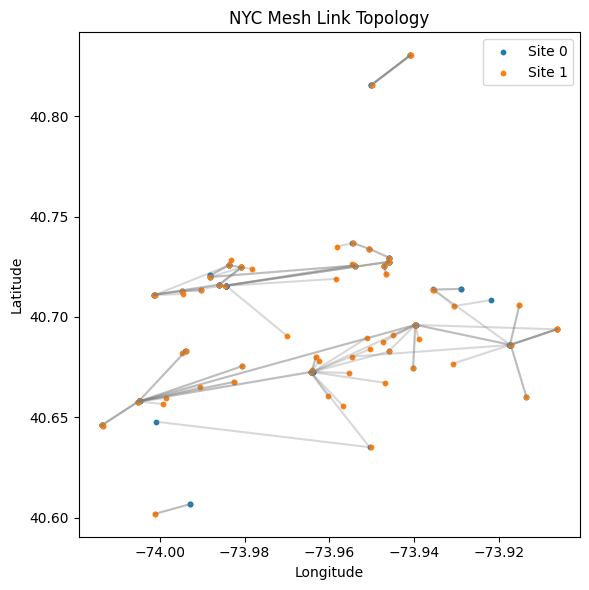

In [6]:
# -----------------------------------------------------------------------------
# 6) Map the network topology (simple scatter)
# -----------------------------------------------------------------------------
lats0, lons0 = ds.site_0_lat.values, ds.site_0_lon.values
lats1, lons1 = ds.site_1_lat.values, ds.site_1_lon.values
plt.figure(figsize=(6,6))
plt.scatter(lons0, lats0, s=10, label="Site 0")
plt.scatter(lons1, lats1, s=10, label="Site 1")
for i in range(len(lats0)):
    plt.plot([lons0[i], lons1[i]], [lats0[i], lats1[i]], color="gray", alpha=0.3)
plt.legend()
plt.title("NYC Mesh Link Topology")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


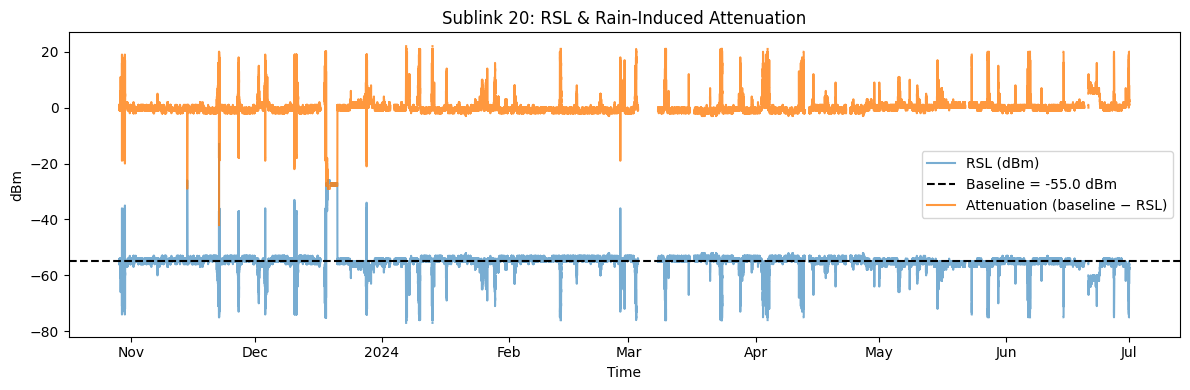

In [7]:
# -----------------------------------------------------------------------------
# 7) Time‐series for a sample link
# -----------------------------------------------------------------------------
slink    = 20
rsl       = ds.rsl.sel(sublink_id=slink)
baseline  = float(rsl.median(dim="time"))
atten     = baseline - rsl

plt.figure(figsize=(12,4))
rsl.plot(label="RSL (dBm)", alpha=0.6)
plt.axhline(baseline, ls="--", color="k", label=f"Baseline = {baseline:.1f} dBm")
atten.plot(label="Attenuation (baseline − RSL)", alpha=0.8)
plt.title(f"Sublink {slink}: RSL & Rain-Induced Attenuation")
plt.xlabel("Time")
plt.ylabel("dBm")
plt.legend()
plt.tight_layout()
plt.show()


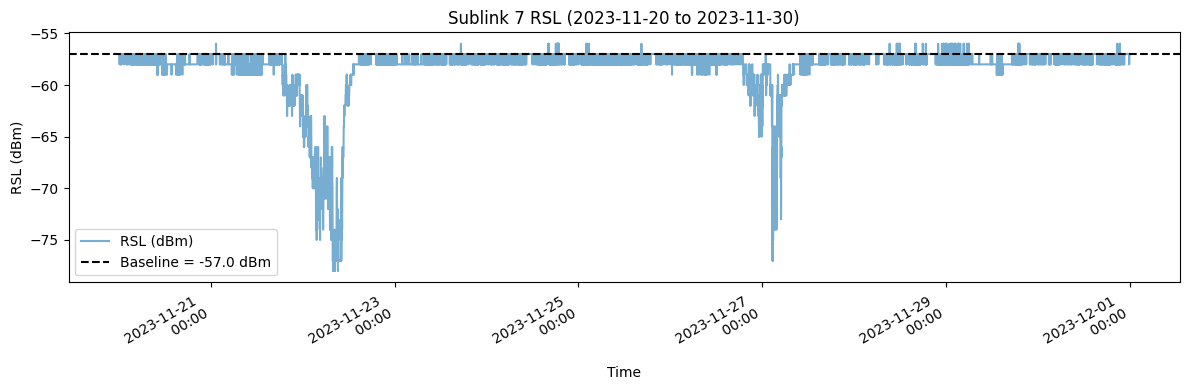

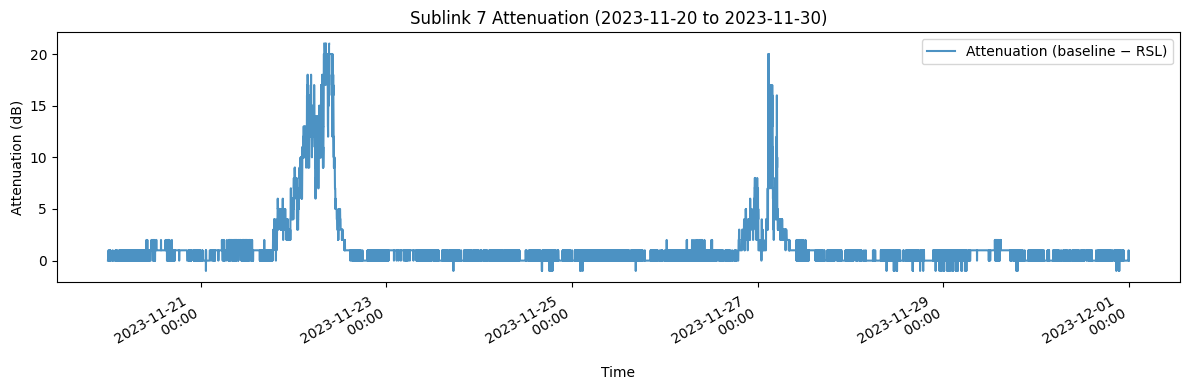

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# -----------------------------------------------------------------------------
# Separate plots: RSL with baseline, then rain-induced attenuation
# -----------------------------------------------------------------------------
slink = 7

# Full series and baseline
rsl_full = ds.rsl.sel(sublink_id=slink)
baseline = float(rsl_full.median(dim="time"))

# Define your optional date range:
start_date = "2023-11-20"
end_date =  "2023-11-30"  # e.g., "2024-02-12" or None for single day

# Convert to numpy.datetime64
start = np.datetime64(start_date)
end = np.datetime64(end_date) if end_date else start

# Slice the data
rsl = rsl_full.sel(time=slice(str(start), str(end)))
atten = baseline - rsl

# Common period label
period = f"{start_date}" + (f" to {end_date}" if end_date else "")

# Plot 1: RSL with baseline
fig, ax = plt.subplots(figsize=(12, 4))
rsl.plot(ax=ax, label="RSL (dBm)", alpha=0.6)
ax.axhline(baseline, linestyle="--", color="k", label=f"Baseline = {baseline:.1f} dBm")
ax.set_title(f"Sublink {slink} RSL ({period})")
ax.set_xlabel("Time")
ax.set_ylabel("RSL (dBm)")
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d \n %H:%M"))
fig.autofmt_xdate()
plt.tight_layout()

# Plot 2: Rain-induced attenuation
fig, ax = plt.subplots(figsize=(12, 4))
atten.plot(ax=ax, label="Attenuation (baseline − RSL)", alpha=0.8)
ax.set_title(f"Sublink {slink} Attenuation ({period})")
ax.set_xlabel("Time")
ax.set_ylabel("Attenuation (dB)")
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d \n %H:%M"))
fig.autofmt_xdate()
plt.tight_layout()

plt.show()
